08/20/2020

SCC Vocab Finder

In [1]:
# basic packages
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import itertools
from collections import Counter, defaultdict
import time
# Import tools needed for visualization
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt

In [2]:
save_dir = '../data/processed/fig4_modelling/vocab_sum/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [3]:
TISSUE = 'SCC'

In [4]:
MAX_DIST=135


In [5]:
#get tfs
tf_df = pd.read_csv('../data/external/transcription_factor_info_063020.csv')
TFS = sorted(set(tf_df[tf_df['cell_type']=='Keratinocytes']["tf"]))##### DIFFERENT FOR EACH TISSUE
print(len(TFS))
print(TFS)


97
['ATF1', 'ATF2', 'ATF3', 'ATF4', 'ATF5', 'BARX2', 'CEBPA', 'CEBPG', 'DLX3', 'DLX5', 'E2F1', 'E2F3', 'E2F4', 'E2F7', 'ELF5', 'ESRRA', 'ETS1', 'ETV4', 'FOS', 'FOSL1', 'FOSL2', 'FOXF2', 'FOXK2', 'FOXP1', 'GRHL1', 'GRHL2', 'HES1', 'HES2', 'HOMEZ', 'HOXA1', 'HOXC11', 'HOXC13', 'ID3', 'IRX2', 'IRX4', 'JUN', 'JUNB', 'JUND', 'KER2', 'KLF16', 'KLF4', 'KLF5', 'LDB2', 'MAF', 'MAFB', 'MAML3', 'NR3C1', 'OTX1', 'OVOL1', 'PBX1', 'PBX2', 'POU1F1', 'POU2F1', 'POU2F2', 'POU2F3', 'POU3F1', 'POU3F2', 'POU3F3', 'POU3F4', 'POU4F1', 'POU4F2', 'POU4F3', 'POU5F1', 'POU5F1B', 'POU6F1', 'POU6F2', 'PRDM1', 'PRRX1', 'RARG', 'RELB', 'RORA', 'RUNX1', 'SMAD4', 'SOX11', 'SOX15', 'SOX6', 'SOX7', 'SOX9', 'SP1', 'SP3', 'STAT1', 'STAT6', 'TCF4', 'TCF7L2', 'TFAP2A', 'TFAP2B', 'TFAP2C', 'TFAP2D', 'TFDP1', 'TP63', 'TWIST2', 'VDR', 'VGLL1', 'XBP1', 'ZBTB7B', 'ZEB1', 'ZNF219']


In [6]:
vocab_dir = '../data/processed/fig4_modelling/tf_tf_pairs/'

read in loop_types

In [7]:
glob.glob('../data/processed/fig4_modelling/tf_tf_pairs_scc/'+'*loop_type*')

['../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_A431-CTRLi_loop_type.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_SCC13-CTRLi_loop_type.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_A431-CTRLi_loop_type.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_SCC13-CTRLi_loop_type.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_CAL27-CTRLi_loop_type.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_CAL27-CTRLi_loop_type.csv']

# 1 understand the types of vocabularies pulled out and where they come from

## 1A. enriched vocabularies from unique tissue genes

In [8]:
loop_type_df_1 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_A431-CTRLi_loop_type.csv',index_col=0).fillna('')
loop_type_df_2 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_CAL27-CTRLi_loop_type.csv',index_col=0).fillna('')
loop_type_df_3 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_SCC13-CTRLi_loop_type.csv',index_col=0).fillna('')


In [9]:
loop_type_df_all = loop_type_df_1[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]+loop_type_df_2[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]+loop_type_df_3[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]
loop_type_df_all['pro_loop_count'] = loop_type_df_all['pro_loop_count']+ loop_type_df_all['loop_pro_count']
loop_type_df_all = loop_type_df_all[['pro_pro_count','pro_loop_count','loop_loop_count']]
loop_type_df_all[:5]

,pro_pro_count,pro_loop_count,loop_loop_count
EGR2::EGR3,0,0,23
EGR2::EGR4,1,2,61
EGR2::ELF3,0,1,43
EGR2::FLI1,0,0,0
EGR2::FOXJ3,0,0,39


In [10]:
# for motifs
# 1. get motifs
motifs = set()
for vocab_pair in loop_type_df_all.index.values:
    v1, v2 = vocab_pair.split('::')
    motifs.add(v1)
    motifs.add(v2)
motifs = sorted(motifs)
print(len(motifs))

# 2. initialize counts
motif_counts_dict = {}
for motif in motifs:
    motif_counts_dict[motif] = {'pro_pro_count':0,'loop_loop_count':0,'pro_loop_count':0} #list of counts for pro_pro_count, loop_loop_count, pro_loop_count, respectively
    
# 3. run through loop_type_df to fill in motif_counts_dict
for vocab_pair, row in loop_type_df_all.iterrows():
    v1, v2 = vocab_pair.split('::')
    motif_counts_dict[v1]['pro_pro_count'] +=row['pro_pro_count']
    motif_counts_dict[v2]['pro_pro_count'] +=row['pro_pro_count']
    motif_counts_dict[v1]['loop_loop_count'] +=row['loop_loop_count']
    motif_counts_dict[v2]['loop_loop_count'] +=row['loop_loop_count']
    motif_counts_dict[v1]['pro_loop_count'] +=row['pro_loop_count']
    motif_counts_dict[v2]['pro_loop_count'] +=row['pro_loop_count']
            
motif_counts_df = pd.DataFrame.from_dict(motif_counts_dict,orient='index')   
motif_counts_df_norm = motif_counts_df/motif_counts_df.sum(axis=0)
motif_counts_df_norm_sel = motif_counts_df_norm.reset_index()[motif_counts_df_norm.reset_index()['index'].isin(TFS)]
motif_counts_df_norm_sel.set_index('index',inplace=True)

20


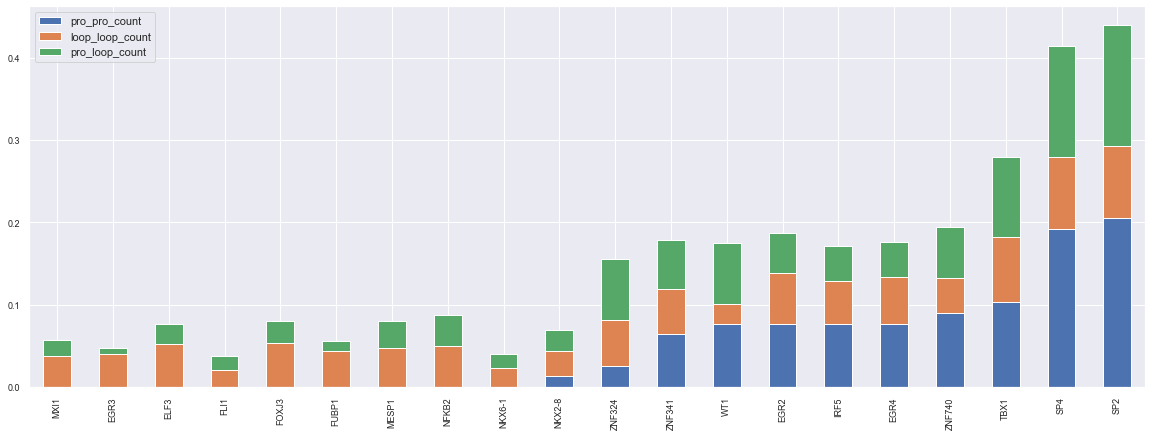

In [48]:
# all tfs
ax = motif_counts_df_norm.sort_values('pro_pro_count').plot(kind='bar', stacked=True,figsize = (20,7),fontsize=9)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_diff_config_count_bar.pdf'))


In [49]:
#same graph as before but only for tissue specific TFS

# ax = motif_counts_df_norm_sel.sort_values('pro_pro_count').plot(kind='bar', stacked=True,figsize = (10,7),fontsize=12)
# ax.figure.savefig(os.path.join(save_dir, TISSUE+'_diff_config_count_sel_bar.pdf'))


this shows the likelihood of the motif appears in a vocab pair from pro_pro, pro_loop, or loop_loop configurations, GIVEN that it does appear at all (so normalized by both the probability of the configuration type as well as by the motif frequency itself


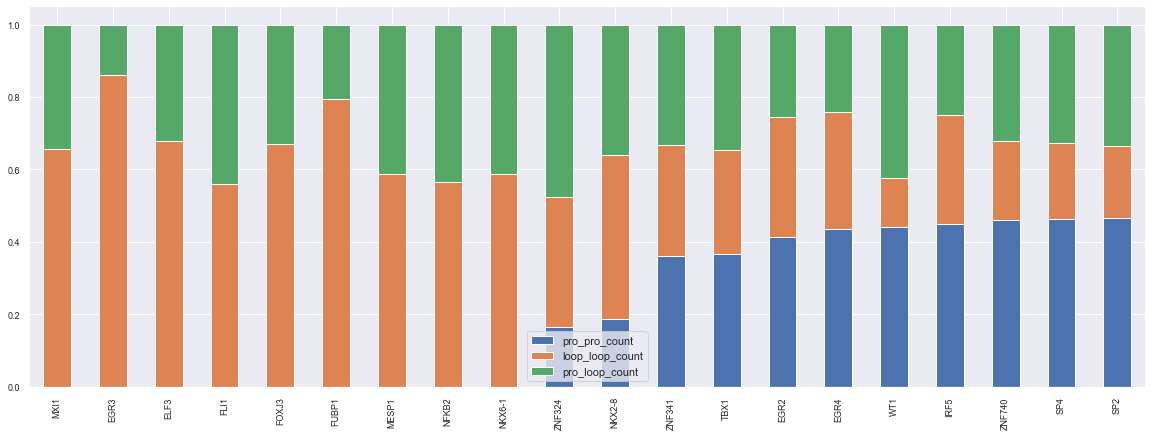

In [50]:
ax = motif_counts_df_norm.div(motif_counts_df_norm.sum(axis=1),axis=0).sort_values('pro_pro_count').plot(kind='bar', stacked=True,
                                                                                                    figsize = (20,7),fontsize=9)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_diff_config_count_norm_bar.pdf'))


In [51]:
# ax = motif_counts_df_norm_sel.div(motif_counts_df_norm_sel.sum(axis=1),axis=0).sort_values('pro_pro_count').plot(kind='bar', stacked=True,
#                                                                                                     figsize = (10,7),fontsize=12)
# ax.figure.savefig(os.path.join(save_dir, TISSUE+'_diff_config_count_norm_sel_bar.pdf'))


## 1b enriched vocab from expressed genes in all scc lines

In [52]:
loop_type_df_1 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_A431-CTRLi_loop_type.csv',index_col=0).fillna('')
loop_type_df_2 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_CAL27-CTRLi_loop_type.csv',index_col=0).fillna('')
loop_type_df_3 = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_SCC13-CTRLi_loop_type.csv',index_col=0).fillna('')


In [53]:
loop_type_df_all = loop_type_df_1[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]+loop_type_df_2[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]+loop_type_df_3[['pro_pro_count','pro_loop_count','loop_pro_count','loop_loop_count']]
loop_type_df_all['pro_loop_count'] = loop_type_df_all['pro_loop_count']+ loop_type_df_all['loop_pro_count']
loop_type_df_all = loop_type_df_all[['pro_pro_count','pro_loop_count','loop_loop_count']]
loop_type_df_all[:5]

,pro_pro_count,pro_loop_count,loop_loop_count
ALX4::ARNT,0,0,5
ALX4::ARNTL,0,0,4
ALX4::BATF3,0,0,0
ALX4::CBFB,0,0,4
ALX4::CEBPZ,0,0,6


In [54]:
# for motifs
# 1. get motifs
motifs = set()
for vocab_pair in loop_type_df_all.index.values:
    v1, v2 = vocab_pair.split('::')
    motifs.add(v1)
    motifs.add(v2)
motifs = sorted(motifs)
print(len(motifs))

# 2. initialize counts
motif_counts_dict = {}
for motif in motifs:
    motif_counts_dict[motif] = {'pro_pro_count':0,'loop_loop_count':0,'pro_loop_count':0} #list of counts for pro_pro_count, loop_loop_count, pro_loop_count, respectively
    
# 3. run through loop_type_df to fill in motif_counts_dict
for vocab_pair, row in loop_type_df_all.iterrows():
    v1, v2 = vocab_pair.split('::')
    motif_counts_dict[v1]['pro_pro_count'] +=row['pro_pro_count']
    motif_counts_dict[v2]['pro_pro_count'] +=row['pro_pro_count']
    motif_counts_dict[v1]['loop_loop_count'] +=row['loop_loop_count']
    motif_counts_dict[v2]['loop_loop_count'] +=row['loop_loop_count']
    motif_counts_dict[v1]['pro_loop_count'] +=row['pro_loop_count']
    motif_counts_dict[v2]['pro_loop_count'] +=row['pro_loop_count']
            
motif_counts_df = pd.DataFrame.from_dict(motif_counts_dict,orient='index')   
motif_counts_df_norm = motif_counts_df/motif_counts_df.sum(axis=0)
motif_counts_df_norm_sel = motif_counts_df_norm.reset_index()[motif_counts_df_norm.reset_index()['index'].isin(TFS)]
print(motif_counts_df_norm_sel.shape)
motif_counts_df_norm_sel.set_index('index',inplace=True)

176
(21, 4)


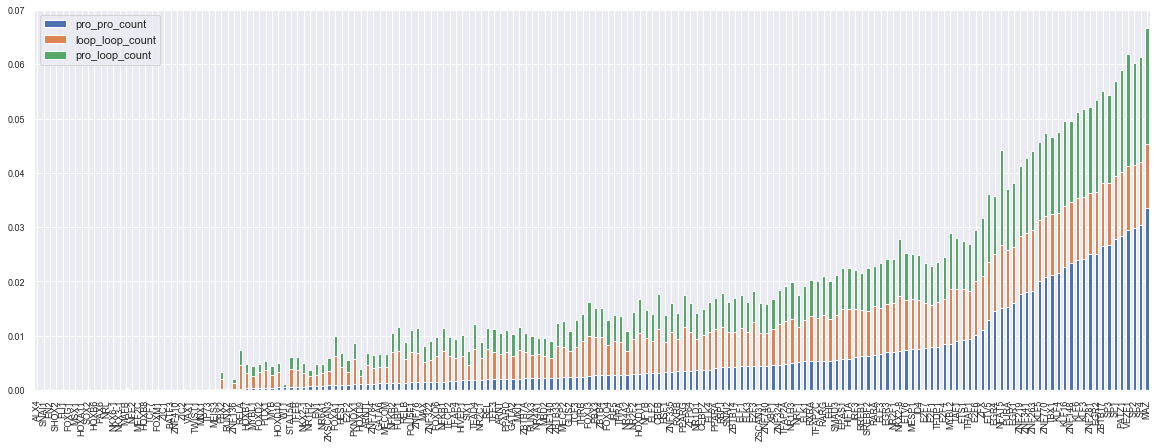

In [55]:
# all tfs
ax = motif_counts_df_norm.sort_values('pro_pro_count').plot(kind='bar', stacked=True,figsize = (20,7),fontsize=9)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_expr_config_count_bar.pdf'))


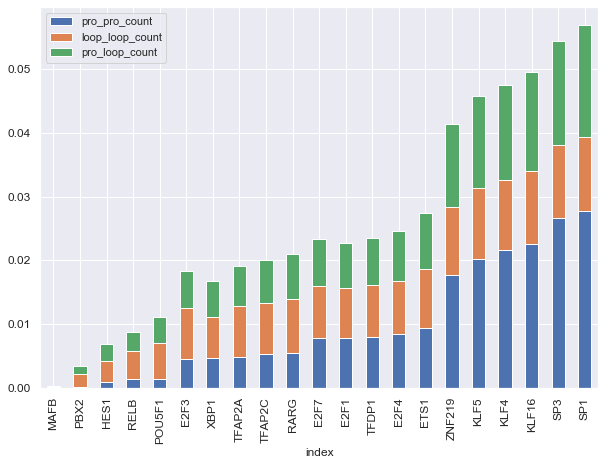

In [56]:
#same graph as before but only for tissue specific TFS

ax = motif_counts_df_norm_sel.sort_values('pro_pro_count').plot(kind='bar', stacked=True,figsize = (10,7),fontsize=12)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_expr_config_count_sel_bar.pdf'))


this shows the likelihood of the motif appears in a vocab pair from pro_pro, pro_loop, or loop_loop configurations, GIVEN that it does appear at all (so normalized by both the probability of the configuration type as well as by the motif frequency itself


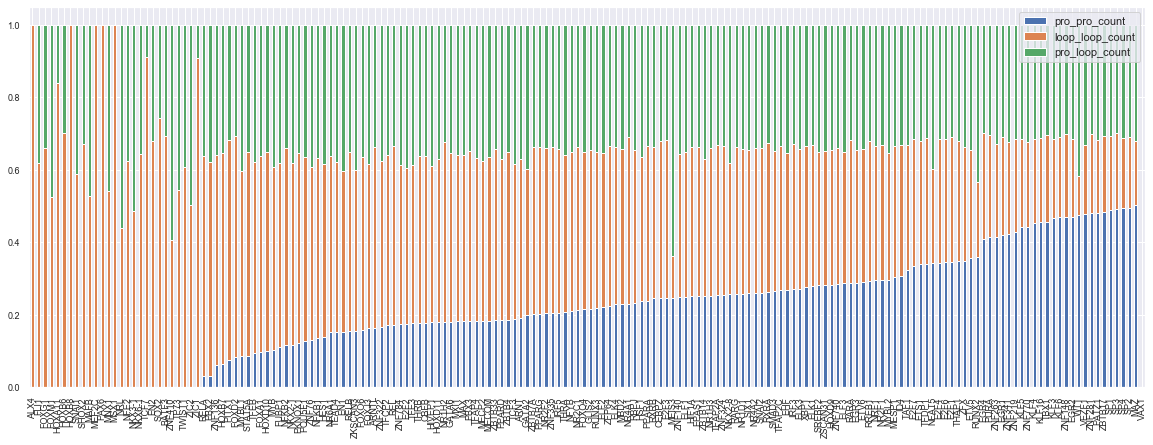

In [57]:
ax = motif_counts_df_norm.div(motif_counts_df_norm.sum(axis=1),axis=0).sort_values('pro_pro_count').plot(kind='bar', stacked=True,
                                                                                                    figsize = (20,7),fontsize=9)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_expr_config_count_norm_bar.pdf'))


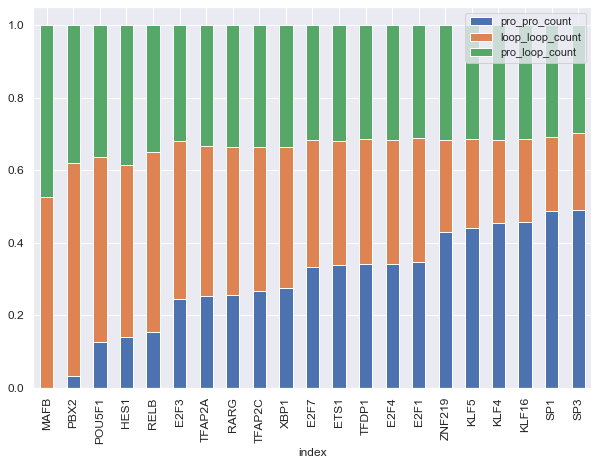

In [58]:
ax = motif_counts_df_norm_sel.div(motif_counts_df_norm_sel.sum(axis=1),axis=0).sort_values('pro_pro_count').plot(kind='bar', stacked=True,
                                                                                                    figsize = (10,7),fontsize=12)
ax.figure.savefig(os.path.join(save_dir, TISSUE+'_expr_config_count_norm_sel_bar.pdf'))


# 2. Vocabulary genomic instances - setup


## 2A. find the locations

In [11]:
sorted(glob.glob('../data/processed/fig4_modelling/tf_tf_pairs_scc/'+'*vocab*'))

['../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_A431-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_A431-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_CAL27-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_CAL27-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_SCC13-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/diff_SCC13-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_A431-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_A431-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_CAL27-CTRLi_loop_loop_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_CAL27-CTRLi_pro_pro_vocab_info.csv',
 '../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_SCC13-CT

## 2B helper functions

In [12]:
def get_other_vocab_word(row, next_row):
    if row['vocab']!=next_row['vocab']:
        return False
    
    vocab_word = set(row['tf'])
    vocab_set = set(row['vocab'].split('::'))
    other_vocab = list(vocab_set -  vocab_word)[0]
    return other_vocab == next_row['tf']

def check_distance(row,next_row,max_dist=MAX_DIST):
    if row['chr_m']==next_row['chr_m']:
        if row['stop_m']<next_row['start_m']:
            tot_dist = next_row['stop_m'] - row['start_m']
            btn_dist = next_row['start_m'] - row['stop_m']
            return (tot_dist < max_dist), tot_dist, btn_dist
    return False,-1,-1

def check_tissue(row,next_row,tfs=TFS):
    if (row['tf'] in tfs) & (next_row['tf'] in tfs):
        return 'both'
    elif (row['tf'] in tfs) | (next_row['tf'] in tfs):
        return 'one'    
    else:
        return 'none'
    
def get_hits(vocab_file,tfs=TFS):
    print('**** reading', vocab_file)
    vocab_df = pd.read_csv(vocab_file)
    print(vocab_df.shape)
    idx = 0
    idx_hits = 0
    results_dict = {}
    while idx < (vocab_df.shape[0]-1):
        # look at next 
        row = vocab_df.iloc[idx,:]
        next_row = vocab_df.iloc[idx+1,:]

        check_vocab_pair = get_other_vocab_word(row,next_row)
        check_dist,tot_dist, btn_dist = check_distance(row, next_row)
        check_tissue_tf = check_tissue(row,next_row,tfs)
        if (check_dist and check_vocab_pair):
    #         print('hi',idx)
    #         print(row)
    #         print(next_row)

            results_dict[idx_hits] = {'vocab_pair':row['vocab'],'tot_dist':tot_dist,'btn_dist':btn_dist,
                                      'chr':row['chr'],'start':row['start_m'],'stop':next_row['stop_m'], 
                                      'vocab1':row['tf'],'vocab1_start':row['start_m'], 'vocab1_stop': row['stop_m'],
                                      'vocab2':next_row['tf'],'vocab2_start':next_row['start_m'], 'vocab2_stop': next_row['stop_m'],
                                      'genes':row['genes'],'num_genes':len(row['genes'].split('|')), 'tissue':row['tissue'],
                                     'check_tissuetf':check_tissue_tf}
            idx_hits+=1

        idx+=1
    print('num_hits',idx_hits)
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    return results_df
    
def filter_results(results_df,min_hits_per_vocab=10):
    print('shape', results_df.shape)
    vocab_counts = results_df.vocab_pair.value_counts()
    print('original num vocab',vocab_counts.shape[0])
    vocab_to_include = vocab_counts[vocab_counts>min_hits_per_vocab].index.values
    print('filt num vocab',vocab_to_include.shape[0])
    
    results_df_filt = results_df[results_df.vocab_pair.isin(vocab_to_include)]
    return results_df_filt

    

# 3. Vocabulary genomic instances - running

## 3A get expression and stability for loop-loop regions


run through all 3 tissue types

and then 

In [56]:
# ###TESTING PURPOSES
# vocab_df = pd.read_csv('../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD6_pro_pro_vocab_info.csv')
# print(vocab_df.shape)
# vocab_df[:5]
TISSUE = 'SCC13-CTRLi'#'CAL27-CTRLi'#'A431-CTRLi'
type_enrich = 'expr_'

In [57]:
%%time
# filtered so that at least 10 genomic instances of vocab pair in significantly found in expressed genes 
results_expr_pro_pro = get_hits('../data/processed/fig4_modelling/tf_tf_pairs_scc/'+type_enrich+TISSUE+'_pro_pro_vocab_info.csv')


**** reading ../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_SCC13-CTRLi_pro_pro_vocab_info.csv
(441040, 15)
num_hits 49602
CPU times: user 2min 51s, sys: 369 ms, total: 2min 51s
Wall time: 2min 50s


In [58]:
%%time
### TAKES AWHILE
results_expr_loop_loop = get_hits('../data/processed/fig4_modelling/tf_tf_pairs_scc/'+type_enrich+TISSUE+'_loop_loop_vocab_info.csv')


**** reading ../data/processed/fig4_modelling/tf_tf_pairs_scc/expr_SCC13-CTRLi_loop_loop_vocab_info.csv
(51440, 15)
num_hits 4762
CPU times: user 19.9 s, sys: 53.6 ms, total: 20 s
Wall time: 20 s


## 3B raw statistics (pre genomic instance filter)

In [59]:
motifs_pro_pro = sorted(set(list(results_expr_pro_pro.vocab1.unique())+list(results_expr_pro_pro.vocab2.unique())))
print('num motifs in pro_pro', len(motifs_pro_pro))
print(motifs_pro_pro)


motifs_loop_loop = sorted(set(list(results_expr_loop_loop.vocab1.unique())+list(results_expr_loop_loop.vocab2.unique())))
print('num motifs in loop_loop', len(motifs_loop_loop))
print(motifs_loop_loop)

num motifs in pro_pro 149
['ARNT', 'ARNTL', 'BATF3', 'CBFB', 'CEBPZ', 'E2F1', 'E2F2', 'E2F3', 'E2F4', 'E2F6', 'E2F7', 'EGR1', 'EGR3', 'EHF', 'ELF1', 'ELF2', 'ELF3', 'ELK1', 'ELK3', 'ELK4', 'EN2', 'EPAS1', 'ETS1', 'ETV5', 'ETV6', 'FLI1', 'FOXG1', 'FOXJ3', 'FUBP1', 'GATA2', 'GATA6', 'GLIS2', 'HES1', 'HIF1A', 'HIVEP1', 'HOXB6', 'HOXB7', 'HOXD10', 'HOXD11', 'HSF1', 'IRF3', 'IRF5', 'KLF16', 'KLF3', 'KLF4', 'KLF5', 'KLF6', 'MAFB', 'MAX', 'MAZ', 'MBD2', 'MECOM', 'MECP2', 'MEF2C', 'MEIS3', 'MNX1', 'MSX1', 'MXI1', 'MYB', 'MYBL1', 'MYBL2', 'NFAT5', 'NFE2', 'NFKB1', 'NFKB2', 'NFYB', 'NKX6-1', 'NR1H2', 'NR1H3', 'NR2C1', 'NR2F1', 'NR2F2', 'NR4A1', 'NR4A2', 'NRF1', 'NRL', 'PATZ1', 'PBX2', 'PBX3', 'PITX1', 'PKNOX1', 'PPARA', 'PPARD', 'PPARG', 'PURA', 'RARA', 'RARG', 'RBPJ', 'REL', 'RELA', 'RELB', 'RREB1', 'RUNX3', 'RXRA', 'RXRB', 'SHOX2', 'SIX1', 'SMAD3', 'SNAI1', 'SNAI2', 'SOX2', 'SP1', 'SP2', 'SP3', 'SP4', 'SREBF2', 'TAF1', 'TBX1', 'TCF3', 'TEAD4', 'TFAP2A', 'TFAP2C', 'TFAP4', 'TFCP2', 'TFDP1', 'TF

In [60]:
print('pre genomic instance filter')
print('num vocab in expression enrichment (pro-pro region): ', results_expr_pro_pro.vocab_pair.unique().shape[0])
print('num vocab in expression enrichment (loop-loop region): ', results_expr_loop_loop.vocab_pair.unique().shape[0])

pre genomic instance filter
num vocab in expression enrichment (pro-pro region):  4757
num vocab in expression enrichment (loop-loop region):  2396


## 3C. filter expression enriched vocab words if then have at least 10 genomic instances then get stats

In [61]:
results_expr_pro_pro = filter_results(results_expr_pro_pro,min_hits_per_vocab=10)
# print(results_expr_pro_pro.vocab_pair.unique().shape)
# results_expr_pro_pro.vocab_pair.unique()

shape (49602, 16)
original num vocab 4757
filt num vocab 970


In [62]:
results_expr_loop_loop = filter_results(results_expr_loop_loop,min_hits_per_vocab=10)
# print(results_expr_loop_loop.vocab_pair.unique().shape)
# results_expr_loop_loop.vocab_pair.unique()

shape (4762, 16)
original num vocab 2396
filt num vocab 0


In [63]:
print('post genomic instance filter')
print('num vocab in expression enrichment (pro-pro region): ', results_expr_pro_pro.vocab_pair.unique().shape[0])
print(results_expr_pro_pro.vocab_pair.unique())
print('num vocab in expression enrichment (loop-loop region): ', results_expr_loop_loop.vocab_pair.unique().shape[0])
print(results_expr_loop_loop.vocab_pair.unique())


post genomic instance filter
num vocab in expression enrichment (pro-pro region):  970
['ARNT::KLF3' 'ARNT::PATZ1' 'ARNT::SP1' 'CBFB::NFAT5' 'CEBPZ::KLF3'
 'CEBPZ::PATZ1' 'CEBPZ::SP1' 'E2F1::KLF3' 'E2F1::KLF5' 'E2F1::KLF6'
 'E2F1::PATZ1' 'E2F1::SP1' 'E2F1::SP3' 'E2F1::ZFX' 'E2F1::ZNF148'
 'E2F1::ZNF219' 'E2F1::ZNF281' 'E2F4::WT1' 'E2F4::ZFX' 'E2F4::ZNF219'
 'E2F6::EGR1' 'E2F6::FLI1' 'E2F6::KLF16' 'E2F6::KLF3' 'E2F6::KLF4'
 'E2F6::KLF5' 'E2F6::KLF6' 'E2F6::MAZ' 'E2F6::NFAT5' 'E2F6::PATZ1'
 'E2F6::SP1' 'E2F6::SP3' 'E2F6::SP4' 'E2F6::TAF1' 'E2F6::VEZF1'
 'E2F6::WT1' 'E2F6::ZBTB17' 'E2F6::ZFX' 'E2F6::ZNF148' 'E2F6::ZNF219'
 'E2F6::ZNF263' 'E2F6::ZNF281' 'E2F6::ZNF770' 'E2F7::WT1' 'E2F7::ZFX'
 'E2F7::ZNF148' 'E2F7::ZNF219' 'EGR1::ELF1' 'EGR1::ELK1' 'EGR1::FLI1'
 'EGR1::KLF16' 'EGR1::KLF3' 'EGR1::KLF4' 'EGR1::KLF5' 'EGR1::KLF6'
 'EGR1::MAZ' 'EGR1::NFAT5' 'EGR1::NR2F1' 'EGR1::PATZ1' 'EGR1::PURA'
 'EGR1::SP1' 'EGR1::SP2' 'EGR1::SP3' 'EGR1::SP4' 'EGR1::TAF1' 'EGR1::TBX1'
 'EGR1::TFAP2A' 'EGR1::

## 3D filter expr vocab words based on whether there is they are annotated for skin

In [64]:
results_expr_pro_pro[['vocab_pair','check_tissuetf']].drop_duplicates().check_tissuetf.value_counts()

none    726
one     326
both    244
Name: check_tissuetf, dtype: int64

In [65]:
results_expr_loop_loop[['vocab_pair','check_tissuetf']].drop_duplicates().check_tissuetf.value_counts()

Series([], Name: check_tissuetf, dtype: int64)

shows fraction of vocab words having tissue specific motif configuration (`both` are tissue specific, `one` is tissue specific, or `none` are)


MAKE SURE #s are around 40 ish so pick `one` or `both`

In [66]:
filter_thres = ['both']#'both' # 'one'#'none','one',
results_expr_pro_pro_tissue = results_expr_pro_pro[results_expr_pro_pro.check_tissuetf.isin(filter_thres)]
print('pro-pro region')
print('total vocab:',results_expr_pro_pro.vocab_pair.unique().shape[0],'tissue annon vocab:', results_expr_pro_pro_tissue.vocab_pair.unique().shape[0])
print(results_expr_pro_pro_tissue.vocab_pair.unique())

results_expr_loop_loop_tissue = results_expr_loop_loop[results_expr_loop_loop.check_tissuetf.isin(filter_thres)]
print('loop-loop region')
print('total vocab:',results_expr_loop_loop.vocab_pair.unique().shape[0],'tissue annon vocab:', results_expr_loop_loop_tissue.vocab_pair.unique().shape[0])
print(results_expr_loop_loop_tissue.vocab_pair.unique())

pro-pro region
total vocab: 970 tissue annon vocab: 244
['ARNT::SP1' 'CEBPZ::SP1' 'E2F1::KLF5' 'E2F1::KLF6' 'E2F1::SP1'
 'E2F1::SP3' 'E2F1::ZNF219' 'E2F4::WT1' 'E2F4::ZFX' 'E2F4::ZNF219'
 'E2F6::KLF5' 'E2F6::SP1' 'E2F7::WT1' 'E2F7::ZFX' 'E2F7::ZNF148'
 'E2F7::ZNF219' 'EGR1::KLF5' 'EGR1::SP1' 'EGR1::SP3' 'EGR3::KLF5'
 'EGR3::SP1' 'EGR3::SP3' 'EHF::SP3' 'ELF1::KLF5' 'ELF1::SP1' 'ELF1::SP3'
 'ELF2::KLF5' 'ELF2::SP1' 'ELF2::SP3' 'ELF3::KLF5' 'ELF3::SP1' 'ELF3::SP3'
 'ELK1::KLF4' 'ELK1::KLF5' 'ELK1::SP1' 'ELK1::SP3' 'ELK4::KLF4'
 'ELK4::KLF5' 'ELK4::SP1' 'ELK4::SP3' 'EPAS1::KLF5' 'ETS1::KLF5'
 'ETS1::SP1' 'ETS1::SP2' 'ETS1::SP3' 'ETS1::SP4' 'ETS1::WT1' 'ETV5::KLF5'
 'ETV6::KLF5' 'ETV6::SP1' 'FLI1::KLF5' 'FLI1::SP1' 'FLI1::SP3'
 'HIF1A::KLF5' 'HSF1::SP1' 'IRF3::SP1' 'IRF5::SP1' 'KLF16::KLF4'
 'KLF16::KLF5' 'KLF16::MAZ' 'KLF16::SNAI2' 'KLF16::SP1' 'KLF16::SP3'
 'KLF16::TAF1' 'KLF16::TFAP2C' 'KLF16::WT1' 'KLF16::ZBTB14'
 'KLF16::ZNF219' 'KLF3::KLF5' 'KLF4::KLF5' 'KLF4::KLF6' 'KLF4::MAZ'
 'KLF4

## 3E add in stability scores vocab pairs that pass the genomic instance filter and get genomic instance counts

In [67]:
def get_counts(results_df, label):
    counts_df = pd.DataFrame(results_df.vocab_pair.value_counts())
    counts_df.columns = ['num_instance']
    counts_df['label']=label
    return counts_df

In [68]:
vocab_summary_df = pd.concat([# get_counts(results_stability_pro_pro, 'stability_pro'),
            get_counts(results_expr_pro_pro_tissue, 'expr_pro_tissue'),
#             get_counts(results_stability_loop_loop, 'stability_loop'),
            get_counts(results_expr_loop_loop_tissue, 'expr_loop_tissue')
        ],
    axis=0)
vocab_summary_df.index.set_names('vocab',inplace=True)
vocab_summary_df.reset_index(inplace=True)
vocab_summary_df = vocab_summary_df.groupby('vocab').agg({'num_instance':sum, 'label':'|'.join}).reset_index()
vocab_summary_df['tissue']=TISSUE
vocab_summary_df.label.value_counts()
# results_stability_loop_loop.vocab_pair.unique()

expr_pro_tissue    244
Name: label, dtype: int64

In [69]:
vocab_summary_df.to_csv(os.path.join(save_dir, TISSUE+'_vocab_summary.csv'))
print('saved:', os.path.join(save_dir, TISSUE+'_vocab_summary.csv'))

saved: ../data/processed/fig4_modelling/vocab_sum/SCC13-CTRLi_vocab_summary.csv


# 4. manual run all 3 tissue types

look at the *vocab_summary.csv

manually pair down list to one xlsx

`vocab_sum/scc_filtered_vocab_list.xlsx`



In [71]:
glob.glob( os.path.join(save_dir, '*_vocab_summary.csv'))

['../data/processed/fig4_modelling/vocab_sum/SCC13-CTRLi_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/GM12878_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/A431-CTRLi_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/Melanocytes_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/Colon_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/GDSD6_vocab_summary.csv',
 '../data/processed/fig4_modelling/vocab_sum/CAL27-CTRLi_vocab_summary.csv']

In [76]:
scc_df = pd.concat([pd.read_csv('../data/processed/fig4_modelling/vocab_sum/A431-CTRLi_vocab_summary.csv',index_col=0),
          pd.read_csv('../data/processed/fig4_modelling/vocab_sum/CAL27-CTRLi_vocab_summary.csv',index_col=0),
          pd.read_csv('../data/processed/fig4_modelling/vocab_sum/SCC13-CTRLi_vocab_summary.csv',index_col=0)],axis=0)
scc_df

,vocab,num_instance,label,tissue
0,ARNT::SP1,13,expr_pro_tissue,A431-CTRLi
1,CBFB::SP1,15,expr_loop_tissue,A431-CTRLi
2,CEBPZ::KLF5,12,expr_pro_tissue,A431-CTRLi
3,CEBPZ::SP1,62,expr_pro_tissue,A431-CTRLi
4,CEBPZ::SP3,26,expr_pro_tissue,A431-CTRLi
...,...,...,...,...
239,TFDP1::ZNF219,12,expr_pro_tissue,SCC13-CTRLi
240,VEZF1::ZNF219,22,expr_pro_tissue,SCC13-CTRLi
241,WT1::ZNF219,18,expr_pro_tissue,SCC13-CTRLi
242,ZBTB14::ZNF219,18,expr_pro_tissue,SCC13-CTRLi


In [108]:
scc_df_tissue3 = scc_df.groupby('vocab').agg({'tissue': '|'.join,'num_instance':sum, 'label': lambda x: '|'.join(list(set(x)))})
scc_df_tissue3 = scc_df_tissue3[scc_df_tissue3.tissue=='A431-CTRLi|CAL27-CTRLi|SCC13-CTRLi'].reset_index()

In [109]:
scc_df_tissue3['tissue']= 'cancer'
scc_df_tissue3

,vocab,tissue,num_instance,label
0,ARNT::SP1,cancer,36,expr_pro_tissue
1,CEBPZ::SP1,cancer,125,expr_pro_tissue
2,E2F1::KLF5,cancer,54,expr_pro_tissue
3,E2F1::SP1,cancer,231,expr_pro_tissue|expr_loop_tissue|expr_pro_tissue
4,E2F1::ZNF219,cancer,40,expr_pro_tissue
...,...,...,...,...
150,TFAP2C::ZNF219,cancer,42,expr_pro_tissue
151,TFAP2C::ZNF770,cancer,15,expr_pro_tissue
152,TFDP1::ZNF219,cancer,35,expr_pro_tissue
153,VEZF1::ZNF219,cancer,50,expr_pro_tissue


In [110]:
scc_df_tissue3.to_csv( os.path.join(save_dir, 'SCC_all_vocab_summary.csv'))

,Unnamed: 0,tf_key,tissue,jaccard,intersect_over_min,intersection,union,num_in_gene,num_in_feat,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
0,0,ARID3A::ARID5B,GDSD0,0.021416,0.079688,12471.0,582315.0,438288.0,156498.0,12471.0,8888.033645,1.450960,4.403910e-307,4.042790e-303,100.000000
1,1,ARID3A::ATF2,GDSD0,0.005609,0.073615,2645.0,471573.0,438288.0,35930.0,2645.0,2040.582301,1.322135,2.215500e-40,2.033829e-36,35.691686
2,2,ARID3A::ATF4,GDSD0,0.002683,0.092291,1208.0,450169.0,438288.0,13089.0,1208.0,743.367151,1.691745,2.395415e-59,2.198991e-55,54.657777
3,3,ARID3A::ATF7,GDSD0,0.002795,0.084686,1263.0,451939.0,438288.0,14914.0,1263.0,847.014874,1.539210,1.225235e-43,1.124766e-39,38.948938
4,4,ARID3A::BACH2,GDSD0,0.003453,0.166522,1540.0,445996.0,438288.0,9248.0,1540.0,525.224189,3.327991,6.554794e-309,6.017301e-305,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9175,9175,ZNF563::ZNF816,GDSD0,0.006367,0.110751,2941.0,461902.0,438288.0,26555.0,2941.0,1508.145366,2.076235,8.350647e-253,7.665894e-249,100.000000
9176,9176,ZNF563::ZNF85,GDSD0,0.004131,0.084959,1895.0,458698.0,438288.0,22305.0,1895.0,1266.773955,1.545060,2.137555e-65,1.962275e-61,60.707240
9177,9177,ZNF768::ZNF816,GDSD0,0.004764,0.126709,2159.0,453168.0,438288.0,17039.0,2159.0,967.700579,2.417612,2.537783e-258,2.329685e-254,100.000000
9178,9178,ZNF768::ZNF85,GDSD0,0.002474,0.087028,1113.0,449964.0,438288.0,12789.0,1113.0,726.329169,1.585879,1.511432e-43,1.387494e-39,38.857769


In [130]:
# normal_df = pd.read_csv('../data/processed/fig4_modelling/vocab_sum/GDSD6_vocab_summary.csv',index_col=0)
normal_df =pd.concat([pd.read_csv( '../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD0_pair_filt_unique.csv'),
    pd.read_csv( '../data/processed/fig4_modelling/tf_tf_pairs/expr_GDSD3_pair_filt_unique.csv')],axis=0)

normal_df = normal_df[normal_df.pval_bonf <0.05]

In [131]:
normal_df

,Unnamed: 0,tf_key,tissue,jaccard,intersect_over_min,intersection,union,num_in_gene,num_in_feat,observed,expected,oddsratio,pval,pval_bonf,log_pval_bonf
0,3,ARID3A::ATF7,GDSD0,0.002795,0.084686,1263.0,451939.0,438288.0,14914.0,1263.0,847.014874,1.539210,1.225235e-43,1.124766e-39,38.948938
1,7,ARID3A::BCL6,GDSD0,0.002387,0.089610,1072.0,449179.0,438288.0,11963.0,1072.0,679.417925,1.637625,2.680205e-47,2.460428e-43,42.608989
2,8,ARID3A::BHLHE41,GDSD0,0.002516,0.086153,1133.0,450306.0,438288.0,13151.0,1133.0,746.888334,1.568412,1.959155e-42,1.798505e-38,37.745088
3,10,ARID3A::CREB5,GDSD0,0.002847,0.085113,1287.0,452122.0,438288.0,15121.0,1287.0,858.771082,1.547735,1.932642e-45,1.774166e-41,40.751006
4,16,ARID3A::EPAS1,GDSD0,0.006042,0.070837,2876.0,476012.0,438288.0,40600.0,2876.0,2305.806886,1.268301,1.204277e-32,1.105526e-28,27.956431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,2990,ZNF467::ZNF667,GDSD3,0.012931,0.150619,8699.0,672718.0,623662.0,57755.0,8699.0,4279.251578,2.233391,0.000000e+00,0.000000e+00,100.000000
1332,2992,ZNF467::ZNF85,GDSD3,0.013287,0.140630,9019.0,678776.0,623662.0,64133.0,9019.0,4751.817876,2.060485,0.000000e+00,0.000000e+00,100.000000
1333,2996,ZNF502::ZNF85,GDSD3,0.001539,0.111686,972.0,631393.0,623662.0,8703.0,972.0,644.832941,1.573460,2.005296e-36,6.021903e-33,32.220266
1334,3001,ZNF667::ZNF85,GDSD3,0.001573,0.122803,992.0,630748.0,623662.0,8078.0,992.0,598.524703,1.752151,7.534295e-54,2.262549e-50,49.645402


In [138]:
len(sorted(set(normal_df.tf_key.values)))

6090

In [139]:
len(set(scc_df_tissue3.vocab.values))

155

In [133]:
set(scc_df_tissue3.vocab.values).intersection(set(normal_df.tf_key.values))

set()

TypeError: savefig() missing 1 required positional argument: 'fname'

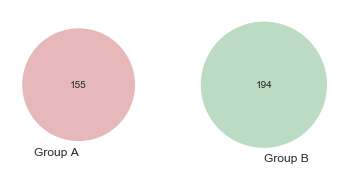

In [104]:
from matplotlib_venn import venn2

 
# Second way
fig = plt.figure()
plt.rcParams['figure.facecolor'] = 'white'

venn2([set(scc_df_tissue3.vocab.values), set(normal_df.vocab.values)],set_labels = ('Group A', 'Group B'))
plt.savefig()


SCC vocab works were filter for those that were not in D0, D3, (or D6) vocab words and then filtered down to 40 words